In [1]:
import datetime
import gc
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

data_dir = Path.home() / 'Desktop/kaggle/data/lanl'
os.environ['DATA_DIR'] = str(data_dir)

In [2]:
import lightgbm as lgb
from tensorflow import keras
from catboost import Pool, CatBoostRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import RFECV, SelectFromModel

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [3]:
!ls -lh $DATA_DIR

total 6.3G
-rw-r----- 1 maekawa primarygroup  75K May 31 20:54 CatBoost_2019-05-31_test_2.055_train_1.806.csv
-rw-r----- 1 maekawa primarygroup  76K Jun  1 01:18 CatBoost_2019-06-01_test_1.848_train_1.534.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 02:53 CatBoost_2019-06-01_test_1.982_train_1.671.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 15:41 CatBoost_2019-06-01_test_2.008_train_1.667.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 17:34 CatBoost_2019-06-01_test_2.105_train_1.810.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 19:29 CatBoost_2019-06-01_test_2.108_train_1.763.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 19:08 CatBoost_2019-06-01_test_2.112_train_1.830.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 21:12 CatBoost_2019-06-01_test_2.113_train_1.814.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 21:39 CatBoost_2019-06-01_test_2.147_train_1.815.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 22:20 CatBoost_2019-06-01_test_2.156_train_1.743.csv

In [5]:
X_train = pd.read_pickle(data_dir / 'df_xtrain_stratified_v5.pickle')
y_train = pd.read_pickle(data_dir / 'df_ytrain_submean_v5.pickle')
X_test = pd.read_pickle(data_dir / 'df_xtest_extra_v5.pickle')

In [6]:
print("Train X: {} y: {} Test X: {}".format(X_train.shape, y_train.shape, X_test.shape))

Train X: (16626, 384) y: (16626, 2) Test X: (2624, 382)


In [7]:
y_train['oof_pred'] = X_train.oof_pred

In [8]:
X_train.sort_values(by='oof_pred', ascending=False, inplace=True)
y_train.sort_values(by='oof_pred', ascending=False, inplace=True)

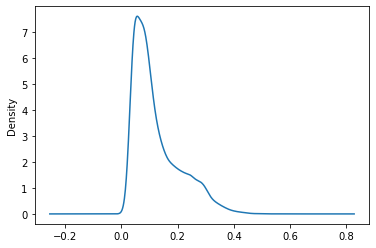

In [9]:
X_train.oof_pred.plot.density()

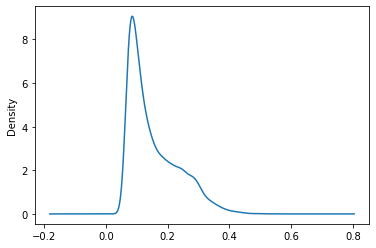

In [10]:
X_train.oof_pred.iloc[:12000].plot.density()

In [11]:
N = 12000
X_train = X_train.iloc[:N]
y_train = y_train.iloc[:N]

In [12]:
y_train.head()

,time_to_failure,time_from_prev_failure,oof_pred
7838,2.106297,14.001104,0.557664
2446,1.856398,12.324202,0.517562
14891,5.546096,9.205704,0.515157
2586,0.492299,13.688301,0.505886
14948,4.990697,9.761103,0.498655


In [13]:
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)

In [14]:
del X_train['oof_pred']
del X_train['target']

In [15]:
print(X_train.shape)
print(X_test.shape)

(12000, 382)
(2624, 382)


In [16]:
discriminators_top250 = [
 'x_med',
 'x_abs_min',
 'fftr_abs_min',
 'time_from_prev_failure',
 'x_q01_roll_mean_100',
 'x_ave10',
 'fftr_av_change_abs_roll_mean_10',
 'fftr_classic_sta_lta3_mean',
 'ffti_q01_roll_std_10',
 'fftr_min_roll_std_1000',
 'fftr_q01_roll_std_10',
 'fftr_abs_q01',
 'ffti_classic_sta_lta3_mean',
 'x_min_roll_mean_100',
 'fftr_av_change_abs_roll_std_100',
 'x_classic_sta_lta3_mean',
 'x_Hann_window_mean',
 'fftr_min_roll_std_100',
 'x_q01_roll_std_1000',
 'ffti_q01_roll_std_100',
 'ffti_q05_roll_std_10',
 'fftr_av_change_abs_roll_mean_1000',
 'ffti_abs_q01',
 'x_min_roll_std_100',
 'x_max_to_min_diff',
 'fftr_max_to_min',
 'x_ave_roll_mean_100',
 'x_max_to_min',
 'x_q95_roll_mean_1000',
 'ffti_min_roll_std_1000',
 'ffti_mean',
 'fftr_q05_roll_mean_10',
 'x_min_roll_mean_1000',
 'x_q99_roll_mean_1000',
 'fftr_av_change_abs_roll_mean_100',
 'x_q01_roll_mean_1000',
 'x_mean',
 'ffti_skew',
 'ffti_min_roll_std_100',
 'x_avg_last_10000',
 'x_abs_max_roll_mean_1000',
 'ffti_ave10',
 'x_q05_roll_mean_100',
 'x_Moving_average_6000_mean',
 'fftr_min_roll_std_10',
 'x_classic_sta_lta4_mean',
 'x_classic_sta_lta2_mean',
 'x_q05',
 'x_min_roll_std_1000',
 'fftr_mean_change_abs',
 'ffti_av_change_abs_roll_std_1000',
 'x_classic_sta_lta1_mean',
 'fftr_med',
 'ffti_q05_roll_std_1000',
 'ffti_min_roll_std_10',
 'ffti_av_change_abs_roll_std_10',
 'x_Moving_average_1500_mean',
 'ffti_q01_roll_std_1000',
 'x_q99_roll_mean_100',
 'x_Moving_average_700_mean',
 'x_std_roll_mean_1000',
 'x_abs_q05',
 'fftr_skew',
 'fftr_av_change_abs_roll_std_10',
 'x_min_roll_std_10',
 'fftr_q05_roll_std_10',
 'fftr_min_roll_mean_1000',
 'ffti_med',
 'fftr_av_change_abs_roll_std_1000',
 'fftr_q01_roll_std_100',
 'x_q05_roll_std_1000',
 'fftr_q95_roll_mean_1000',
 'x_av_change_abs_roll_std_100',
 'x_abs_trend',
 'x_Moving_average_3000_mean',
 'ffti_mean_change_abs',
 'ffti_av_change_abs_roll_std_100',
 'fftr_abs_q05',
 'x_skew',
 'fftr_q05_roll_mean_1000',
 'x_av_change_abs_roll_std_10',
 'x_avg_first_50000',
 'fftr_q95_roll_mean_100',
 'ffti_q05_roll_std_100',
 'fftr_q01_roll_std_1000',
 'x_q95_roll_mean_100',
 'ffti_Moving_average_6000_mean',
 'x_q01_roll_std_10',
 'fftr_ave10',
 'x_kurt',
 'fftr_max_to_min_diff',
 'x_ave_roll_mean_10',
 'ffti_Moving_average_3000_mean',
 'x_max_roll_mean_1000',
 'x_q05_roll_mean_10',
 'x_q05_roll_mean_1000',
 'fftr_q99_roll_mean_1000',
 'x_av_change_abs_roll_std_1000',
 'fftr_max_roll_mean_10',
 'x_q01_roll_std_100',
 'x_avg_last_50000',
 'x_avg_first_10000',
 'fftr_std_roll_mean_1000',
 'x_q95',
 'x_mean_change_abs',
 'ffti_Moving_average_1500_mean',
 'fftr_q05_roll_mean_100',
 'fftr_q05_roll_std_100',
 'fftr_avg_first_50000',
 'ffti_kurt',
 'x_std_first_10000',
 'fftr_q05_roll_std_1000',
 'fftr_q01_roll_mean_1000',
 'fftr_kurt',
 'ffti_trend',
 'x_trend',
 'x_exp_Moving_average_300_mean',
 'fftr_avg_first_10000',
 'x_ave_roll_mean_1000',
 'ffti_std_roll_mean_1000',
 'x_q01_last_10000',
 'fftr_max_roll_mean_1000',
 'ffti_avg_last_50000',
 'x_av_change_abs_roll_mean_10',
 'x_q05_roll_std_100',
 'fftr_q01_roll_mean_10',
 'fftr_min_roll_mean_10',
 'ffti_avg_first_50000',
 'x_std_last_10000',
 'x_q01_last_50000',
 'x_abs_max_roll_mean_100',
 'x_q05_roll_std_10',
 'ffti_abs_q05',
 'ffti_avg_first_10000',
 'x_std_first_50000',
 'x_q99_last_10000',
 'x_av_change_abs_roll_mean_1000',
 'x_av_change_abs_roll_mean_100',
 'fftr_avg_last_10000',
 'x_q95_roll_mean_10',
 'ffti_av_change_abs_roll_mean_1000',
 'fftr_Moving_average_3000_mean',
 'fftr_abs_max_roll_mean_100',
 'x_std_roll_mean_100',
 'x_q99_first_10000',
 'x_q99_roll_std_100',
 'x_min',
 'fftr_abs_max_roll_mean_1000',
 'fftr_q95_roll_mean_10',
 'x_std_last_50000',
 'x_q99_first_50000',
 'ffti_Moving_average_700_mean',
 'x_exp_Moving_average_3000_mean',
 'ffti_Hann_window_mean',
 'ffti_max_roll_mean_10',
 'ffti_q05_roll_mean_1000',
 'x_min_roll_mean_10',
 'fftr_avg_last_50000',
 'ffti_min_roll_mean_100',
 'ffti_avg_last_10000',
 'x_max_roll_mean_100',
 'fftr_max_roll_mean_100',
 'ffti_ave_roll_mean_10',
 'x_q01_first_10000',
 'x_max_roll_mean_10',
 'ffti_max_roll_mean_1000',
 'ffti_max_roll_mean_100',
 'x_q99_last_50000',
 'ffti_max_roll_std_10',
 'ffti_ave_roll_mean_100',
 'x_q99_roll_std_1000',
 'x_q01_first_50000',
 'x_max_roll_std_100',
 'x_exp_Moving_average_30000_mean',
 'x_abs_max_roll_mean_10',
 'fftr_min_roll_mean_100',
 'fftr_Moving_average_6000_mean',
 'ffti_q95_roll_mean_1000',
 'x_q95_roll_std_100',
 'ffti_q01_roll_mean_100',
 'fftr_q01_roll_mean_100',
 'ffti_av_change_abs_roll_mean_10',
 'fftr_abs_max_roll_mean_10',
 'ffti_abs_q99',
 'x_abs_q01',
 'x_abs_q95',
 'x_max_roll_std_10',
 'x_max',
 'fftr_min',
 'fftr_q99_roll_std_1000',
 'fftr_Moving_average_700_mean',
 'ffti_exp_Moving_average_300_mean',
 'ffti_min_roll_mean_10',
 'ffti_ave_roll_mean_1000',
 'fftr_q95_roll_std_1000',
 'fftr_Moving_average_1500_mean',
 'ffti_exp_Moving_average_30000_mean',
 'fftr_abs_max',
 'ffti_std_roll_mean_100',
 'ffti_q01_roll_mean_10',
 'fftr_max_roll_std_10',
 'x_q95_roll_std_10',
 'x_q95_roll_std_1000',
 'x_abs_max',
 'ffti_q99_roll_mean_10',
 'ffti_q05_roll_mean_100',
 'ffti_q01_roll_mean_1000',
 'ffti_q01_last_50000',
 'ffti_min_roll_mean_1000',
 'fftr_q99_first_10000',
 'ffti_q95_roll_std_100',
 'ffti_q99_roll_mean_1000',
 'fftr_max',
 'ffti_max_roll_std_1000',
 'x_q001',
 'x_std_roll_std_10',
 'x_q99',
 'x_std_roll_mean_10',
 'fftr_exp_Moving_average_30000_mean',
 'ffti_q99_first_10000',
 'ffti_exp_Moving_average_3000_mean',
 'ffti_av_change_abs_roll_mean_100',
 'fftr_iqr',
 'ffti_max_roll_std_100',
 'ffti_std_roll_mean_10',
 'fftr_std_roll_mean_100',
 'fftr_q99_roll_mean_10',
 'fftr_q99_roll_std_100',
 'ffti_sum',
 'ffti_max',
 'ffti_q05',
 'ffti_q05_roll_mean_10',
 'fftr_q99_roll_mean_100',
 'fftr_max_roll_std_100',
 'fftr_q95_roll_std_10',
 'x_q99_roll_mean_10',
 'fftr_max_roll_std_1000',
 'ffti_q95_roll_std_1000',
 'fftr_ave_roll_mean_10',
 'ffti_q95_roll_mean_10',
 'ffti_q95_roll_mean_100',
 'ffti_q95_roll_std_10',
 'ffti_q99_roll_std_10',
 'fftr_abs_trend',
 'x_q999',
 'fftr_exp_Moving_average_300_mean',
 'fftr_std_roll_mean_10',
 'x_ave_roll_std_10',
 'x_q01',
 'fftr_q95_roll_std_100']

In [17]:
discriminators_top250__ = [
    'time_from_prev_failure',
    'fftr_max',
    'fftr_abs_max',
] + [
    'ffti_Moving_average_6000_mean',
    'ffti_abs_q01',
    'ffti_av_change_abs_roll_std_10',
    'ffti_av_change_abs_roll_std_100',
    'ffti_av_change_abs_roll_std_1000',
    'ffti_classic_sta_lta3_mean',
    'ffti_mean_change_abs',
    'ffti_min_roll_std_10',
    'ffti_min_roll_std_100',
    'ffti_min_roll_std_1000',
    'ffti_q01_roll_std_100',
    'ffti_q05_roll_std_10',
    'ffti_q05_roll_std_1000',
    'fftr_abs_min',
    'fftr_abs_q01',
    'fftr_max_roll_mean_10',
    'fftr_max_roll_mean_100',
    'fftr_max_to_min_diff',
    'fftr_mean_change_abs',
    'fftr_min_roll_std_10',
    'fftr_min_roll_std_100',
    'fftr_q01_roll_std_10',
    'fftr_q01_roll_std_100',
    'fftr_q05_roll_std_10',
    'fftr_q95_roll_mean_1000',
    'x_abs_trend',
    'x_av_change_abs_roll_mean_10',
    'x_av_change_abs_roll_mean_100',
    'x_av_change_abs_roll_std_10',
    'x_av_change_abs_roll_std_100',
    'x_av_change_abs_roll_std_1000',
    'x_avg_first_10000',
    'x_avg_first_50000',
    'x_avg_last_10000',
    'x_classic_sta_lta2_mean',
    'x_classic_sta_lta4_mean',
    'x_max_first_50000',
    'x_max_roll_mean_1000',
    'x_max_to_min',
    'x_max_to_min_diff',
    'x_min_roll_mean_1000',
    'x_min_roll_std_10',
    'x_min_roll_std_100',
    'x_q01_roll_mean_100',
    'x_q05_roll_mean_100',
    'x_q05_roll_mean_1000',
    'x_q05_roll_std_10',
    'x_q95_roll_mean_1000',
    'x_q99_roll_mean_1000',
    'x_skew',
] + [
    'fftr_abs_max_roll_mean_10',
    'ffti_q01_roll_std_10',
    'fftr_abs_max_roll_mean_100',
    'fftr_min_roll_std_1000',
    'x_q01_roll_mean_1000',
    'ffti_skew',
    'fftr_med',
    'ffti_mean',
    'x_q05_roll_std_100',
    'x_min_roll_mean_100',
    'fftr_av_change_abs_roll_std_10',
    'fftr_q05_roll_mean_1000',
    'fftr_av_change_abs_roll_mean_10',
    'x_avg_last_50000',
    'x_abs_max_roll_mean_1000',
    'ffti_q05_roll_std_100',
    'ffti_avg_first_10000',
    'x_q05_roll_std_1000',
    'ffti_ave10',
    'x_std_roll_mean_1000',
    'x_classic_sta_lta1_mean',
    'ffti_med',
    'fftr_av_change_abs_roll_mean_1000',
    'x_std_first_10000',
    'ffti_q01_roll_std_1000',
    'ffti_trend',
    'x_q95_roll_mean_100',
    'x_min_first_50000',
    'fftr_max_roll_mean_1000',
    'x_min_roll_std_1000',
    'ffti_abs_q05',
    'fftr_q01_roll_std_1000',
    'ffti_kurt',
    'x_av_change_abs_roll_mean_1000',
    'fftr_ave10',
    'x_classic_sta_lta3_mean',
    'fftr_q05_roll_std_100',
    'ffti_Hann_window_mean',
    'fftr_min_roll_mean_1000',
    'fftr_av_change_abs_roll_std_1000',
    'x_q01_roll_std_10',
    'x_q01_roll_std_1000',
    'fftr_avg_first_10000',
    'fftr_q99_roll_mean_1000',
    'x_max_first_10000',
    'ffti_ave_roll_mean_10',
    'x_ave10',
    'ffti_Moving_average_1500_mean',
    'ffti_avg_first_50000',
    'ffti_Moving_average_3000_mean',
] + [
    'x_exp_Moving_average_30000_mean',
    'fftr_av_change_abs_roll_std_100',
    'fftr_abs_trend',
    'ffti_sum',
    'fftr_abs_max_roll_mean_1000',
    'ffti_avg_last_50000',
    'ffti_avg_last_10000',
    'fftr_av_change_abs_roll_mean_100',
    'fftr_avg_last_10000',
    'x_Moving_average_3000_mean',
    'x_min_first_10000',
    'fftr_q95_roll_mean_100',
    'x_exp_Moving_average_3000_mean',
    'fftr_q01_roll_mean_1000',
    'x_q05_roll_mean_10',
    'fftr_max_roll_std_1000',
    'ffti_av_change_abs_roll_mean_10',
    'fftr_Moving_average_6000_mean',
    'fftr_max_roll_std_10',
    'x_q01_roll_std_100',
    'x_q99_roll_mean_100',
    'fftr_q05_roll_std_1000',
    'fftr_avg_last_50000',
    'x_trend',
    'x_min_last_10000',
    'fftr_max_to_min',
    'x_std_first_50000',
    'ffti_ave_roll_mean_100',
    'x_exp_Moving_average_300_mean',
    'ffti_max_roll_std_1000',
    'fftr_trend',
    'fftr_exp_Moving_average_30000_mean',
    'x_max_last_10000',
    'x_max_last_50000',
    'x_std_last_10000',
    'x_iqr',
    'x_Moving_average_6000_mean',
    'ffti_exp_Moving_average_300_mean',
    'ffti_Moving_average_700_mean',
    'ffti_q05_roll_mean_1000',
    'ffti_exp_Moving_average_3000_mean',
    'fftr_abs_q05',
    'x_max',
    'fftr_classic_sta_lta3_mean',
    'ffti_count_big',
    'x_q95_roll_std_1000',
    'fftr_exp_Moving_average_3000_mean',
    'x_Moving_average_1500_mean',
    'x_q95_roll_std_10',
    'x_min_last_50000',
] + [
    'fftr_abs_max_roll_std_10',
    'x_mean',
    'x_Moving_average_700_mean',
    'fftr_std_roll_mean_1000',
    'x_ave_roll_mean_1000',
    'fftr_max_roll_std_100',
    'ffti_av_change_abs_roll_mean_100',
    'ffti_q95_roll_mean_1000',
    'fftr_exp_Moving_average_300_mean',
    'ffti_exp_Moving_average_30000_mean',
    'x_std_last_50000',
    'fftr_q01_roll_mean_100',
    'fftr_avg_first_50000',
    'x_q99_roll_std_1000',
    'x_Hann_window_mean',
    'x_mean_change_abs',
    'x_min_roll_mean_10',
    'fftr_q99_roll_mean_100',
    'x_kurt',
    'fftr_min',
    'ffti_max_roll_std_10',
    'x_max_roll_mean_100',
    'fftr_std_first_10000',
    'ffti_std_roll_mean_1000',
    'ffti_iqr',
    'ffti_ave_roll_mean_1000',
    'x_std_roll_mean_100',
    'fftr_Moving_average_3000_mean',
    'fftr_q05_roll_mean_100',
    'fftr_abs_max_roll_std_1000',
    'fftr_min_roll_mean_100',
    'x_min',
    'fftr_min_roll_mean_10',
    'x_q95_roll_std_100',
    'ffti_av_change_abs_roll_mean_1000',
    'ffti_max_to_min_diff',
    'fftr_max_last_50000',
    'ffti_max_roll_mean_1000',
    'x_max_roll_mean_10',
    'x_max_roll_std_10',
    'ffti_std_roll_mean_100',
    'x_q95_roll_mean_10',
    'ffti_q01_roll_mean_1000',
    'x_max_roll_std_100',
    'fftr_q95_roll_std_100',
    'ffti_min_first_50000',
    'ffti_max_roll_mean_100',
    'ffti_max_roll_mean_10',
    'ffti_q05_roll_mean_100',
    'x_MA_400MA_BB_low_mean'
] + [
    'x_sum',
    'fftr_abs_max_roll_std_100',
    'x_abs_max',
    'x_abs_max_roll_std_10',
    'x_ave_roll_mean_100',
    'x_ave_roll_mean_10',
    'x_abs_max_roll_mean_100',
    'ffti_q99_roll_mean_1000',
    'ffti_abs_max_roll_std_10',
    'fftr_min_first_50000',
    'x_q001',
    'ffti_min_roll_mean_10',
    'fftr_max_last_10000',
    'ffti_min_roll_mean_1000',
    'x_abs_max_roll_mean_10',
    'ffti_min_roll_mean_100',
    'fftr_std_roll_mean_100',
    'ffti_q95',
    'ffti_abs_max_roll_std_1000',
    'fftr_iqr',
    'ffti_q95_roll_mean_100',
    'fftr_Moving_average_700_mean',
    'fftr_count_big',
    'fftr_q95',
    'x_max_roll_std_1000',
    'x_abs_max_roll_std_100',
    'fftr_q999',
    'ffti_abs_max_roll_mean_1000',
    'fftr_ave_roll_mean_1000',
    'ffti_q01_roll_mean_100',
    'fftr_Hann_window_mean',
    'x_MA_700MA_BB_low_mean',
    'x_q01_roll_mean_10',
    'x_Hilbert_mean',
    'fftr_q95_roll_std_10',
    'fftr_ave_roll_mean_10',
    'fftr_Moving_average_1500_mean',
    'ffti_q95_roll_std_100',
    'ffti_max_roll_std_100',
    'fftr_classic_sta_lta4_mean',
    'fftr_q05_roll_mean_10',
    'fftr_q01_roll_mean_10',
    'fftr_q95_roll_mean_10',
    'ffti_abs_max_roll_mean_100',
    'x_q999',
    'x_q99_roll_mean_10',
    'fftr_q95_roll_std_1000',
    'fftr_min_first_10000',
    'ffti_q05_roll_mean_10',
    'ffti_min_last_50000'
]

In [18]:
train_columns = list(X_train.columns)

for f in discriminators_top250:
    if f in train_columns:
        train_columns.remove(f)

len(train_columns)

132

# Time To Previous Failure

%%time

y_train_label = y_train.time_from_prev_failure
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=False, random_state=49)

tfpf_oof = np.zeros(len(X_train))
train_score = []
fold_idxs = []
tfpf_predictions = np.zeros(len(X_test))

feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train_label.values)):
    strLog = "# Fold {}".format(fold_)
    print(strLog)
    fold_idxs.append(val_idx)

    X_tr, X_val = X_train[train_columns].iloc[trn_idx], X_train[train_columns].iloc[val_idx]
    y_tr, y_val = y_train_label.iloc[trn_idx], y_train_label.iloc[val_idx]

    model = CatBoostRegressor(n_estimators=25000, verbose=-1, objective="MAE", loss_function="MAE", boosting_type="Ordered", task_type="GPU")
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_val, y_val)], 
              verbose=2500, 
              early_stopping_rounds=500)
    tfpf_oof[val_idx] = model.predict(X_val)

    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    tfpf_predictions += model.predict(X_test[train_columns]) / folds.n_splits
    train_score.append(model.best_score_['learn']["MAE"])

cv_score = mean_absolute_error(y_train_label, tfpf_oof)
print(f"After {n_fold} test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")

tfpf_col = 'time_from_prev_failure'
X_train[tfpf_col] = tfpf_oof
X_test[tfpf_col] = tfpf_predictions
if tfpf_col not in train_columns:
    train_columns.append(tfpf_col)

# Catboost

In [19]:
y_train_label = y_train.time_to_failure

In [20]:
# cb_params = {
#  'bootstrap_type': 'Bernoulli',
#  'leaf_estimation_backtracking': 'AnyImprovement',
#  'l2_leaf_reg': 3.1884879156314594,
#  'learning_rate': 0.15692972872529823,
#  'depth': 8,
#  'max_bin': 18,
#  'fold_len_multiplier': 1.4665755301338386,
#  'random_strength': 0.005213763775616797,    
# }

In [21]:
%%time

y_train_label = y_train.time_to_failure
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)

oof = np.zeros(len(X_train))
train_score = []
fold_idxs = []
predictions = np.zeros(len(X_test))

feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train_label.values)):
    strLog = "# Fold {}".format(fold_)
    print(strLog)
    fold_idxs.append(val_idx)

    X_tr, X_val = X_train[train_columns].iloc[trn_idx], X_train[train_columns].iloc[val_idx]
    y_tr, y_val = y_train_label.iloc[trn_idx], y_train_label.iloc[val_idx]

    model = CatBoostRegressor(
        n_estimators=25000, verbose=-1, objective="MAE", loss_function="MAE",
        boosting_type="Ordered", task_type="GPU")
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_val, y_val)], 
              verbose=2500,
              early_stopping_rounds=1000)
    oof[val_idx] = model.predict(X_val)

    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(X_test[train_columns]) / folds.n_splits
    train_score.append(model.best_score_['learn']["MAE"])

cv_score = mean_absolute_error(y_train_label, oof)

print(f"After {n_fold} test_CV = {cv_score:.3f} | "
      f"train_CV = {np.mean(train_score):.3f} | "
      f"{cv_score-np.mean(train_score):.3f}")

# Fold 0
0:	learn: 5.3830416	test: 5.5956177	best: 5.5956177 (0)	total: 30.7ms	remaining: 12m 46s
2500:	learn: 1.9649302	test: 1.9023779	best: 1.9023779 (2500)	total: 1m 11s	remaining: 10m 38s
5000:	learn: 1.8645894	test: 1.8987624	best: 1.8984731 (4744)	total: 2m 22s	remaining: 9m 28s
7500:	learn: 1.7837510	test: 1.8968746	best: 1.8967155 (7478)	total: 3m 33s	remaining: 8m 18s
10000:	learn: 1.7113218	test: 1.8961560	best: 1.8958993 (9805)	total: 4m 46s	remaining: 7m 9s
bestTest = 1.895899251
bestIteration = 9805
Shrink model to first 9806 iterations.
# Fold 1
0:	learn: 5.4327592	test: 5.3967668	best: 5.3967668 (0)	total: 26.6ms	remaining: 11m 4s
bestTest = 2.599917399
bestIteration = 717
Shrink model to first 718 iterations.
# Fold 2
0:	learn: 5.3965580	test: 5.5415259	best: 5.5415259 (0)	total: 26.1ms	remaining: 10m 52s
2500:	learn: 1.8589380	test: 2.2702555	best: 2.2684949 (2017)	total: 1m 10s	remaining: 10m 31s
bestTest = 2.268494873
bestIteration = 2017
Shrink model to first 2018 

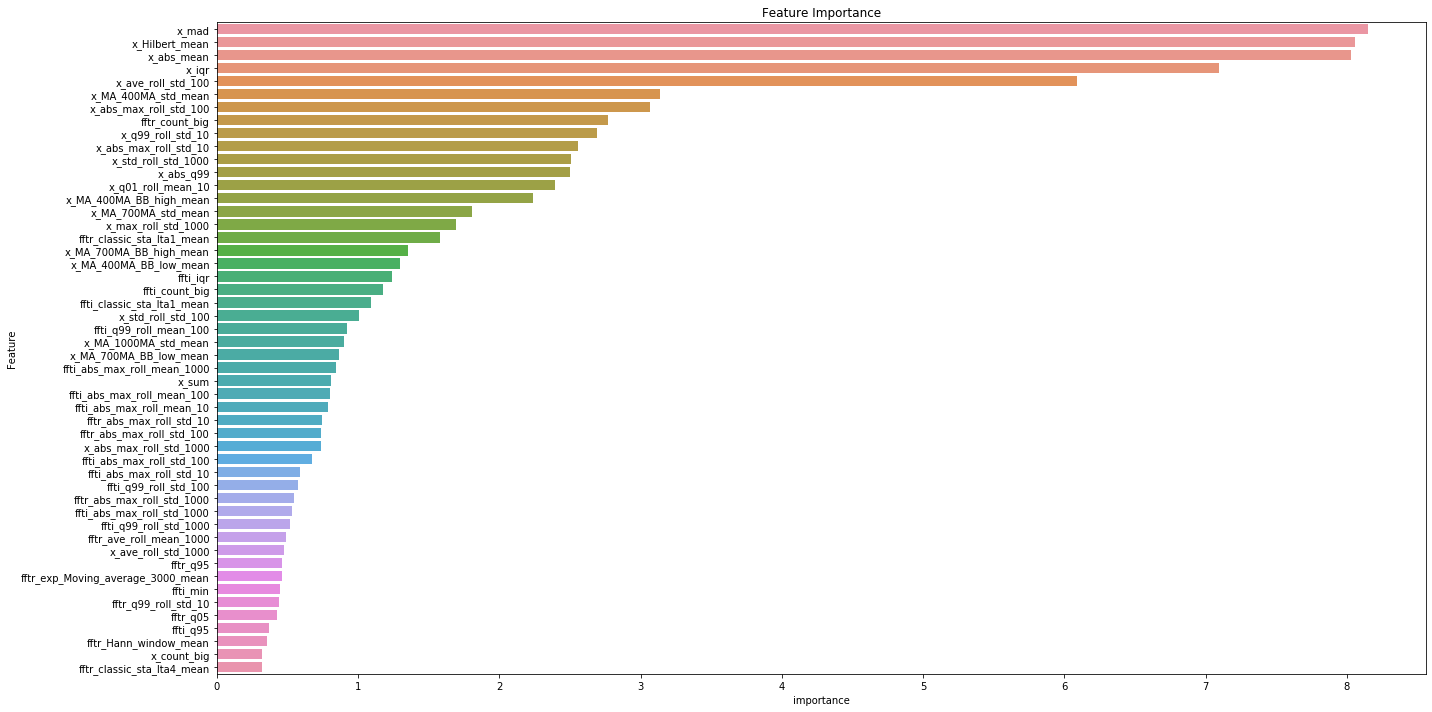

In [22]:
plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="Feature", data=(
    feature_importance_df
    .groupby('Feature')
    .importance.mean()
    .reset_index()
    .sort_values(by='importance', ascending=False)
    .head(50)
))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [23]:
submission = pd.read_csv(data_dir / 'sample_submission.csv')
submission["time_to_failure"] = predictions

today = str(datetime.date.today())
submission_file = f'CatBoost_{today}_test_{cv_score:.3f}_train_{np.mean(train_score):.3f}.csv'
print(submission_file)
submission.to_csv(data_dir / submission_file, index=False)
submission.head()

CatBoost_2019-06-03_test_2.078_train_1.817.csv


,seg_id,time_to_failure
0,seg_00030f,4.365270
1,seg_0012b5,4.171625
2,seg_00184e,4.859852
3,seg_003339,8.096531
4,seg_0042cc,6.199090


## score log
- test_CV = 2.055 | train_CV = 1.806 | public score = 1.473
- test_CV = 1.848 | train_CV = 1.534 | public score = 2.049  # time_from_prev_failure - Overfitting!
- test_CV = 1.982 | train_CV = 1.671 | public score = 1.487

# LightGBM

In [24]:
%%time

params = {
    'boosting': 'gbdt',
    'metric': 'MAE',
    'objective': 'fair',
    "verbosity": 1,

    'bagging_fraction': 0.84,
    'feature_fraction': 0.89,
    'lambda_l1': 3.1182900937385454,
    'lambda_l2': 3.2470389978527785,
    'learning_rate': 0.045592800827466404,
    'max_bin': 241,
    'max_depth': 16,
    'min_data_in_bin': 38,
    'min_data_in_leaf': 3,
    'min_gain_to_split': 1.81,
    'num_leaves': 1813,
    'subsample': 0.9998541677924023,
}

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)

lgb_oof = np.zeros(len(X_train))
train_score = []
fold_idxs = []
lgb_predictions = np.zeros(len(X_test))

lgb_feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train_label.values)):
    strLog = "# Fold {}".format(fold_)
    print(strLog)
    fold_idxs.append(val_idx)

    trn_data = lgb.Dataset(X_train[train_columns].iloc[trn_idx], label=y_train_label.iloc[trn_idx])
    val_data = lgb.Dataset(X_train[train_columns].iloc[val_idx], label=y_train_label.iloc[val_idx])

    num_round = 30000
    clf = lgb.train(params, trn_data, num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=2500,
                    early_stopping_rounds=1000)
    lgb_oof[val_idx] = clf.predict(
        X_train[train_columns].iloc[val_idx],
        num_iteration=clf.best_iteration)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    lgb_feature_importance_df = pd.concat([lgb_feature_importance_df, fold_importance_df], axis=0)
    #predictions
    lgb_predictions += clf.predict(X_test[train_columns]) / folds.n_splits
    train_score.append(clf.best_score['training']['l1'])

cv_score = mean_absolute_error(y_train_label, oof)

print(f"After {n_fold} test_CV = {cv_score:.3f} | "
      f"train_CV = {np.mean(train_score):.3f} | "
      f"{cv_score-np.mean(train_score):.3f}",
      end=" ")

# Fold 0
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[71]	training's l1: 1.64522	valid_1's l1: 1.88269
# Fold 1
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[84]	training's l1: 1.49914	valid_1's l1: 2.70335
# Fold 2
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[44]	training's l1: 1.68352	valid_1's l1: 2.27733
# Fold 3
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[41]	training's l1: 1.83135	valid_1's l1: 1.40041
# Fold 4
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[88]	training's l1: 1.53308	valid_1's l1: 2.3302
After 5 test_CV = 2.078 | train_CV = 1.638 | 0.439 CPU times: user 2h 23min 52s, sys: 4.71 s, total: 2h 23min 57s
Wall time: 13min 24s


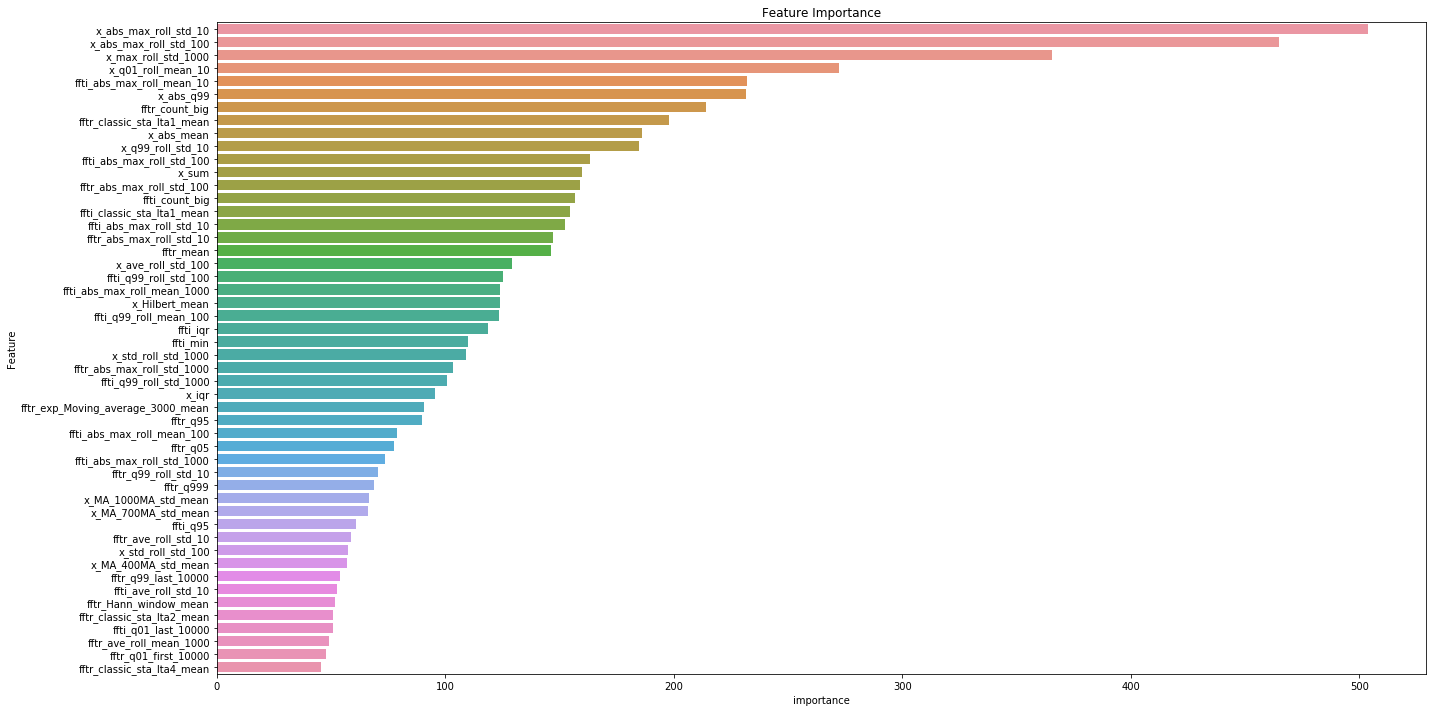

In [25]:
plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="Feature", data=(
    lgb_feature_importance_df
    .groupby('Feature')
    .importance.mean()
    .reset_index()
    .sort_values(by='importance', ascending=False)
    .head(50)
))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [26]:
submission = pd.read_csv(data_dir / 'sample_submission.csv')
submission["time_to_failure"] = predictions

today = str(datetime.date.today())
submission_file = f'LightGBM_{today}_test_{cv_score:.3f}_train_{np.mean(train_score):.3f}.csv'
print(submission_file)
submission.to_csv(data_dir / submission_file, index=False)
submission.head()

LightGBM_2019-06-03_test_2.078_train_1.638.csv


,seg_id,time_to_failure
0,seg_00030f,4.365270
1,seg_0012b5,4.171625
2,seg_00184e,4.859852
3,seg_003339,8.096531
4,seg_0042cc,6.199090


# Keras

In [27]:
scaler = StandardScaler()
X_train[train_columns] = scaler.fit_transform(X_train[train_columns])
X_test[train_columns] = scaler.transform(X_test[train_columns])

In [28]:
def create_model(input_dim=10):
    model = keras.Sequential()
    model.add(keras.layers.Dense(256, activation="relu", input_dim=input_dim))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(96, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(1, activation="linear"))

    optimizer = keras.optimizers.Adam(
        lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #'rmsprop'
    model.compile(optimizer=optimizer,loss='mae')
    return model

patience = 50
call_ES = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=patience, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True)

call_TB = keras.callbacks.TensorBoard(data_dir / 'keras_logs')

In [29]:
%%time

folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)
y_train_label = y_train.time_to_failure

NN_oof = np.zeros(len(X_train))
train_score = []
fold_idxs = []

NN_predictions = np.zeros(len(X_test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,y_train_label.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    fold_idxs.append(val_idx)
    
    X_tr, X_val = X_train[train_columns].iloc[trn_idx], X_train[train_columns].iloc[val_idx]
    y_tr, y_val = y_train_label.iloc[trn_idx], y_train_label.iloc[val_idx]
    model = create_model(len(train_columns))
    model.fit(X_tr, y_tr, epochs=500, batch_size=32, verbose=1,
              callbacks=[call_ES, call_TB],
              validation_data=[X_val, y_val])
    
    NN_oof[val_idx] = model.predict(X_val)[:,0]
    
    NN_predictions += model.predict(X_test[train_columns])[:,0] / folds.n_splits
    history = model.history.history
    tr_loss = history["loss"]
    val_loss = history["val_loss"]
    print(f"loss: {tr_loss[-patience]:.3f} | val_loss: {val_loss[-patience]:.3f} | diff: {val_loss[-patience]-tr_loss[-patience]:.3f}")
    train_score.append(tr_loss[-patience])
    
cv_score = mean_absolute_error(y_train_label, NN_oof)
print(f"After {n_fold} test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")

fold 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 9600 samples, validate on 2400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
9600/9600 [==============================] - 1s 139us/sample - loss: 2.5379 - val_loss: 1.9782
Epoch 2/500
9600/9600 [==============================] - 1s 119us/sample - loss: 2.3055 - val_loss: 1.9477
Epoch 3/500
9600/9600 [==============================] - 1s 119us/sample - loss: 2.2766 - val_loss: 2.1928
Epoch 4/500
9600/9600 [==============================] - 1s 117us/sample - loss: 2.2701 - val_loss: 2.0372
Epoch 5/500
9600/9600 [==============================] - 1s 119us/sample - loss: 2.2506 - val_loss: 1.9322
Epoch 6/500
9600/9600 [==============================] - 1s 119us/sample - loss: 2.2381 - val_loss: 1.8954
Epoch 7/500
9600/9600 [==============================] - 1s 118us/sa

9600/9600 [==============================] - 1s 120us/sample - loss: 2.0509 - val_loss: 2.5843
Epoch 8/500
9600/9600 [==============================] - 1s 119us/sample - loss: 2.0322 - val_loss: 2.6291
Epoch 9/500
9600/9600 [==============================] - 1s 121us/sample - loss: 2.0230 - val_loss: 2.6025
Epoch 10/500
9600/9600 [==============================] - 1s 123us/sample - loss: 2.0170 - val_loss: 2.5766
Epoch 11/500
9600/9600 [==============================] - 1s 120us/sample - loss: 2.0146 - val_loss: 2.6185
Epoch 12/500
9600/9600 [==============================] - 1s 120us/sample - loss: 2.0240 - val_loss: 2.6248
Epoch 13/500
9600/9600 [==============================] - 1s 125us/sample - loss: 2.0158 - val_loss: 2.6112
Epoch 14/500
9600/9600 [==============================] - 1s 124us/sample - loss: 2.0015 - val_loss: 2.6101
Epoch 15/500
9600/9600 [==============================] - 1s 120us/sample - loss: 1.9900 - val_loss: 2.6515
Epoch 16/500
9600/9600 [===================

Epoch 21/500
9600/9600 [==============================] - 1s 123us/sample - loss: 2.0688 - val_loss: 2.3029
Epoch 22/500
9600/9600 [==============================] - 1s 122us/sample - loss: 2.0610 - val_loss: 2.2598
Epoch 23/500
9600/9600 [==============================] - 1s 122us/sample - loss: 2.0815 - val_loss: 2.2732
Epoch 24/500
9600/9600 [==============================] - 1s 122us/sample - loss: 2.0370 - val_loss: 2.2837
Epoch 25/500
9600/9600 [==============================] - 1s 122us/sample - loss: 2.0618 - val_loss: 2.2881
Epoch 26/500
9600/9600 [==============================] - 1s 122us/sample - loss: 2.0672 - val_loss: 2.2778
Epoch 27/500
9600/9600 [==============================] - 1s 121us/sample - loss: 2.0339 - val_loss: 2.2795
Epoch 28/500
9600/9600 [==============================] - 1s 123us/sample - loss: 2.0357 - val_loss: 2.3080
Epoch 29/500
9600/9600 [==============================] - 1s 124us/sample - loss: 2.0409 - val_loss: 2.2752
Epoch 30/500
9600/9600 [====

Epoch 97/500
9600/9600 [==============================] - 1s 122us/sample - loss: 1.9418 - val_loss: 2.2631
Epoch 98/500
9600/9600 [==============================] - 1s 124us/sample - loss: 1.9389 - val_loss: 2.2876
Epoch 99/500
9600/9600 [==============================] - 1s 123us/sample - loss: 1.9496 - val_loss: 2.3053
Epoch 100/500
9600/9600 [==============================] - 1s 126us/sample - loss: 1.9465 - val_loss: 2.2817
Epoch 101/500
9600/9600 [==============================] - 1s 124us/sample - loss: 1.9396 - val_loss: 2.2714
Epoch 102/500
9600/9600 [==============================] - 1s 123us/sample - loss: 1.9393 - val_loss: 2.3152
Epoch 103/500
9600/9600 [==============================] - 1s 121us/sample - loss: 1.9342 - val_loss: 2.2739
Epoch 104/500
9600/9600 [==============================] - 1s 122us/sample - loss: 1.9384 - val_loss: 2.2647
Epoch 105/500
9600/9600 [==============================] - 1s 124us/sample - loss: 1.9295 - val_loss: 2.2948
Epoch 106/500
9600/960

9600/9600 [==============================] - 1s 124us/sample - loss: 2.2399 - val_loss: 1.5026
Epoch 45/500
9600/9600 [==============================] - 1s 123us/sample - loss: 2.2235 - val_loss: 1.3358
Epoch 46/500
9600/9600 [==============================] - 1s 126us/sample - loss: 2.2253 - val_loss: 1.3962
Epoch 47/500
9600/9600 [==============================] - 1s 118us/sample - loss: 2.2294 - val_loss: 1.5195
Epoch 48/500
9600/9600 [==============================] - 1s 117us/sample - loss: 2.2151 - val_loss: 1.3861
Epoch 49/500
9600/9600 [==============================] - 1s 117us/sample - loss: 2.2257 - val_loss: 1.3685
Epoch 50/500
9600/9600 [==============================] - 1s 118us/sample - loss: 2.2234 - val_loss: 1.5777
Epoch 51/500
9600/9600 [==============================] - 1s 125us/sample - loss: 2.2095 - val_loss: 1.2945
Epoch 52/500
9600/9600 [==============================] - 1s 125us/sample - loss: 2.2057 - val_loss: 1.5265
Epoch 53/500
9600/9600 [=================

9600/9600 [==============================] - 1s 126us/sample - loss: 2.0119 - val_loss: 2.3418
Epoch 37/500
9600/9600 [==============================] - 1s 125us/sample - loss: 2.0015 - val_loss: 2.3501
Epoch 38/500
9600/9600 [==============================] - 1s 124us/sample - loss: 1.9950 - val_loss: 2.4283
Epoch 39/500
9600/9600 [==============================] - 1s 127us/sample - loss: 2.0068 - val_loss: 2.3116
Epoch 40/500
9600/9600 [==============================] - 1s 125us/sample - loss: 2.0139 - val_loss: 2.3363
Epoch 41/500
9600/9600 [==============================] - 1s 125us/sample - loss: 2.0037 - val_loss: 2.3468
Epoch 42/500
9600/9600 [==============================] - 1s 126us/sample - loss: 1.9974 - val_loss: 2.3496
Epoch 43/500
9600/9600 [==============================] - 1s 125us/sample - loss: 2.0005 - val_loss: 2.3520
Epoch 44/500
9600/9600 [==============================] - 1s 124us/sample - loss: 1.9843 - val_loss: 2.3523
Epoch 45/500
9600/9600 [=================

In [30]:
sub_nn = pd.read_csv(data_dir / 'sample_submission.csv')
sub_nn["time_to_failure"] = predictions

today = str(datetime.date.today())
sub_file = f'Keras_{today}_test_{cv_score:.3f}_train_{np.mean(train_score):.3f}.csv'
print(sub_file)

Keras_2019-06-03_test_2.046_train_2.100.csv


In [31]:
sub_nn.to_csv(data_dir / sub_file, index=False)
sub_nn.head()

,seg_id,time_to_failure
0,seg_00030f,4.365270
1,seg_0012b5,4.171625
2,seg_00184e,4.859852
3,seg_003339,8.096531
4,seg_0042cc,6.199090
